# Computing Concept Learnability

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
from sklearn.model_selection import train_test_split

def get_cub_features():
    test_images = pickle.load(open('CUB_resnet_baseline//test.pkl', 'rb'))
    test_img_names = []
    test_attr = []
    test_pred = pickle.load(open('CUB_resnet_baseline/test_predictions.pkl', 'rb'))
    test_features = pickle.load(open('CUB_resnet_baseline/imagenet_features.pkl', 'rb'))
    test_logits = pickle.load(open('CUB_resnet_baseline/best_test_scores.pkl', 'rb'))['scores']
    test_feat_array = []
    targets = []
    for i in range(len(test_images)):
        test_img_names.append(test_images[i]['img_path'])
        targets.append(test_images[i]['class_label'])
        #print(test_images[i]['img_path'])
        test_attr.append(test_images[i]['attribute_label'])
        test_feat_array.append(test_features[test_images[i]['img_path']].squeeze())
    test_attr = np.stack(test_attr)
    test_features = np.stack(test_feat_array)
    train_features, valtest_features, train_attr, valtest_attr, train_pred, valtest_pred, train_logits, valtest_logits, train_targets, valtest_targets = train_test_split(test_features, test_attr, test_pred, test_logits, targets, test_size=0.4, random_state = 42)
    val_features, test_features, val_attr, test_attr, val_pred, test_pred, val_logits, test_logits, val_targets, test_targets = train_test_split(valtest_features, valtest_attr, valtest_pred, valtest_logits, valtest_targets, test_size=0.5, random_state = 42)

    features = {'train': train_features, 'val': val_features, 'test': test_features}
    attr = {'train': train_attr, 'val': val_attr, 'test': test_attr}
    predictions = {'train': train_pred, 'val': val_pred, 'test': test_pred}
    logits = {'train': train_logits, 'val': val_logits, 'test': test_logits}
    targets = {'train': train_targets, 'val': val_targets, 'test': test_targets}

    return features, attr, predictions, logits, targets

def get_ade20k_features():
    
    features = {'train':[], 'val':[], 'test':[]}
    attr = {'train':[], 'val':[], 'test':[]}
    predictions = {'train':[], 'val':[], 'test':[]}
    names = {'train':[], 'val':[], 'test':[]}

    A = pickle.load(open('../ADE20k/ade20k_imagelabels_with_texture.pkl', 'rb'))


    for split in ['train', 'val', 'test']:
        img_names = A[split]
        feat_split = pickle.load(open('../ADE20k/{}_imagenet.pkl'.format(split), 'rb'))
        pred_split = pickle.load(open('../ADE20k/{}_scene.pkl'.format(split), 'rb'))
        #logit_split = pickle.load(open('../ADE20k/tra'))
        for img in img_names:
            features[split].append(feat_split[img].squeeze())
            predictions[split].append(pred_split[img])
            temp = np.zeros(1200)
            temp[A['labels'][img]] = 1 
            attr[split].append(temp)

        features[split] = np.stack(features[split])
        predictions[split] = np.array(predictions[split])
        attr[split] = np.stack(attr[split])
        names[split] = img_names
    
    return features, attr, predictions, names

In [37]:
cub_features, cub_attr, cub_predictions, cub_logits, cub_targets = get_cub_features()
ade_features, ade_attr, ade_predictions, ade_names = get_ade20k_features()

## Scene NAPs vs. Broden concepts

In [4]:
ibd_coefs = pickle.load(open('ibd_attr_importances.pkl', 'rb'))

In [7]:
labels = pd.read_csv('../../dataset/broden1_224/label.csv', index_col=0)['name'].to_dict()
label_to_num = {v:k for (k, v) in labels.items()}

In [8]:
attr_needed = []
for sc in range(365):
    for t in ibd_coefs[sc]['attr_coefs']:
        if label_to_num[t]not in attr_needed:
            attr_needed.append(label_to_num[t])

In [10]:
from sklearn.metrics import roc_auc_score

def hyperparam_search_l2(train_features, train_labels, val_features, val_labels, 
                      Cs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5]):
    best_clf = None
    best_auc = 0
    
    for c in Cs:
        clf = LogisticRegression(solver='liblinear', C=c, penalty='l2')
        clf.fit(train_features, train_labels)
        score = roc_auc_score(val_labels, clf.predict_proba(val_features)[:, 1])
        if score>best_auc:
            best_auc = score
            best_clf = clf
    
    return best_clf
        

In [ ]:
attr_clfs = {}

for at in attr_needed:
    
    if train_attr[:, at].mean()==0 or train_attr[:, at].mean()==1:
        print(at)
        continue
    clf = hyperparam_search_l2(ade_features['train'], ade_attr['train'][:, at], 
                              ade_features['val'], ade_attr['val'][:, at])
    attr_clfs[at] = clf

In [11]:
def normalized_ap(targets, scores, N):
    
    sorted_score_idxs = np.argsort(scores).squeeze()
    sorted_scores = scores[sorted_score_idxs]
    sorted_targets = targets[sorted_score_idxs]
    actual_N = targets.sum()
    
    all_recalls = [0]
    all_precisions = []
    
    correct_pos = 0
    wrong_pos = 0
    #print(sorted_scores.shape, sorted_targets.shape, actual_N)
    for i in range(len(sorted_scores)-1,-1, -1):
        if sorted_targets[i]==1:
            correct_pos+=1
        else:
            wrong_pos+=1
        #print((correct_pos/actual_N)*N, wrong_pos)
        all_precisions.append(((correct_pos/actual_N)*N)/((correct_pos/actual_N)*N+wrong_pos))
        all_recalls.append(correct_pos/actual_N)
    
    recall_diffs = np.array(all_recalls[1:]) - np.array(all_recalls[:-1])
    all_precisions = np.array(all_precisions)
    #print(all_precisions, recall_diffs)
    return (recall_diffs*all_precisions).sum()

In [ ]:
NAPs = {}

N = (1/365)*ade_features['test'].shape[0]

for at in attr_clfs:
    if ade_attr['test'][:, at].mean()==0:
        continue
    sc = attr_clfs[at].predict_proba(ade_features['test'])[:, 1]
    NAPs[at] = normalized_ap(ade_attr['test'][:,at], sc, N)

In [12]:
places_logits = pickle.load(open('record/Places365/val_logits.pkl', 'rb'))
places_scores_array = []
places_targets = []
with open('record/Places365/places365_val.txt', 'r') as handle:
    lines = handle.readlines()
    for line in lines:
        t = line.strip().split()
        places_targets.append(int(t[1]))
        places_scores_array.append(places_logits['/n/fs/visualai-scr/Data/Places365/val_256/{}'.format(t[0])])

FileNotFoundError: [Errno 2] No such file or directory: 'record/Places365/val_logits.pkl'

In [ ]:
places_scores_array = np.concatenate(places_scores_array)
places_targets = np.array(places_targets)

In [ ]:
scene_naps = []
for sc in range(365):
    scene_naps.append(normalized_ap(np.where(places_targets==sc, 1, 0), places_scores_array[:, sc], 100))plt.hist(np.array(cub_NAPs_array)*100, bins=np.arange(21)*5)


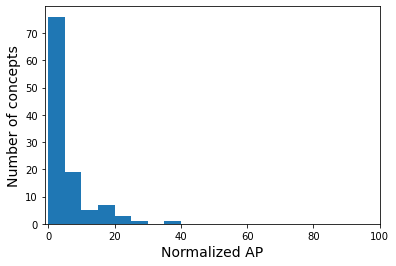

In [46]:
plt.hist(np.array(list(NAPs.values()))*100, bins=np.arange(21)*5)
plt.xlabel('Normalized AP', size=14)
plt.xlim([-1, 100])
plt.ylabel('Number of concepts', size=14)
plt.savefig('ade_attr_aps.eps')


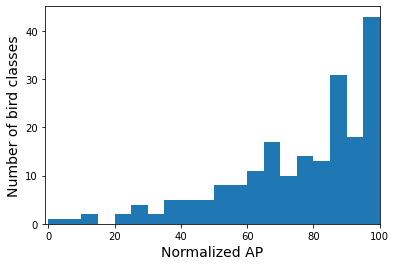

In [47]:
plt.hist(np.array(scene_aps)*100, bins=np.arange(21)*5)
plt.xlabel('Normalized AP', size=14)
plt.xlim([-1, 100])
plt.ylabel('Number of bird classes', size=14)
plt.savefig('scene_aps.eps')

## CUB NAPs vs. CUB concepts

In [13]:
def cub_attributes():
    return [1, 4, 6, 7, 10, 14, 15, 20, 21, 23, 25, 29, 30, 35, 36, 38, 40, 44, 45, 50, 51, 53, 54, 56, 57, 59,
            63, 64, 69, 70, 72, 75, 80, 84, 90, 91, 93, 99, 101, 106, 110, 111, 116, 117, 119, 125, 126, 131,
            132, 134, 145, 149, 151, 152, 153, 157, 158, 163, 164, 168, 172, 178, 179, 181, 183, 187, 188, 193,
            194, 196, 198, 202, 203, 208, 209, 211, 212, 213, 218, 220, 221, 225, 235, 236, 238, 239, 240, 242,
            243, 244, 249, 253, 254, 259, 260, 262, 268, 274, 277, 283, 289, 292, 293, 294, 298, 299, 304, 305,
            308, 309, 310, 311]

imp_attr = cub_attributes()

In [28]:
cub_clfs = {}

for at in imp_attr:
    
    if cub_attr['train'][:, at].mean()==0 or cub_attr['train'][:, at].mean()==1:
        print(at)
        continue
    clf = hyperparam_search_l2(cub_features['train'], cub_attr['train'][:, at], 
                              cub_features['val'], cub_attr['val'][:, at])
    cub_clfs[at] = clf

0.7580194132989164 0.001
0.7677260627571186 0.005
0.9185371006073408 0.001
0.9185491033919869 0.005
0.7383581642584413 0.001
0.7395217239400065 0.005
0.7956205479968341 0.001
0.8024723928692572 0.005
0.8116248693834901 0.001
0.7128362566971926 0.001
0.7144778110745544 0.005
0.8913771806629553 0.001
0.8959965481649436 0.005
0.7416675278255637 0.001
0.7443122048604446 0.001
0.7479364226206473 0.005
0.8111571304392289 0.001
0.8373232569478304 0.001
0.730121210355327 0.001
0.8833552467929356 0.001
0.8861891901496037 0.005
0.7452123564014906 0.001
0.7604339866646513 0.001
0.7631422045313313 0.005
0.8172645002958127 0.001
0.8225124350855666 0.005
0.7750591052376332 0.001
0.7873651188166829 0.005
0.7284243200630667 0.001
0.7375197083169096 0.005
0.7381109578242018 0.01
0.9596321070234114 0.001
0.9629821627647716 0.005
0.8353503123682494 0.001
0.8465658656241615 0.005
0.8050767953244546 0.001
0.8107120444734623 0.005
0.8376877237186793 0.001
0.8421071050052992 0.005
0.7238023682154235 0.001
0.

In [29]:
cub_NAPs = {}

N = (1/200)*cub_features['test'].shape[0]

for at in cub_clfs:
    if cub_attr['test'][:, at].mean()==0:
        continue
    sc = cub_clfs[at].predict_proba(cub_features['test'])[:, 1]
    cub_NAPs[at] = normalized_ap(cub_attr['test'][:,at], sc, N)

In [40]:
cub_class_scores = []

N = (1/200)*cub_logits['test'].shape[0]

for i in range(200):
    sc = cub_logits['test'][:, i]
    cub_class_scores.append(normalized_ap(np.where(np.array(cub_targets['test'])==i, 1, 0), sc, N))

In [41]:
cub_NAPs_array = list(cub_NAPs.values())

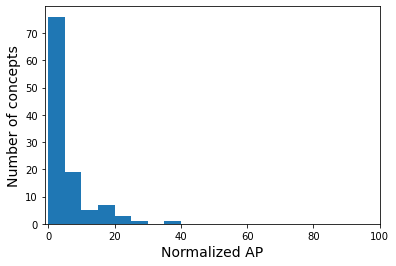

In [46]:
plt.hist(np.array(cub_NAPs_array)*100, bins=np.arange(21)*5)
plt.xlabel('Normalized AP', size=14)
plt.xlim([-1, 100])
plt.ylabel('Number of concepts', size=14)
plt.savefig('cub_attr_aps.eps')


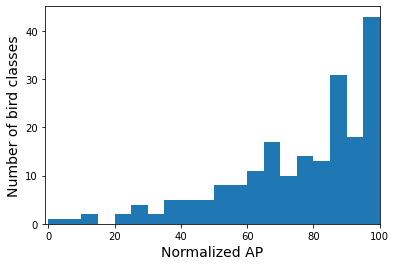

In [47]:
plt.hist(np.array(cub_class_scores)*100, bins=np.arange(21)*5)
plt.xlabel('Normalized AP', size=14)
plt.xlim([-1, 100])
plt.ylabel('Number of bird classes', size=14)
plt.savefig('cub_target_aps.eps')